In [18]:
import pandas as pd
import geopandas as gpd
import numpy as np
from utils.BBI_utils import mergeData, computeBBI, simpleLowpassFilter, getSuperelevation, getAdvisorySpeed, alignData
from utils.LRS_utils import NCATgetReferencePoints, getDistToMid, getReferenceCurve, NCATgetRadius
from utils.NCAT_processing import NCAT_processing
from utils.SR_processing import SR_processing
import math


loc = pd.read_csv(r'2021_03_11_07_36_21_506_loc.csv')
acc = pd.read_csv(r'2021_03_11_07_36_21_506_acc.csv')
crash = pd.read_csv(r'Crashdata.csv')
# Chooses certain columns
crash = crash.filter(items=['Road_Name', 'KABCO_Seve', 'Manner_of_', 'Location_a', 'Latitude', 'Longitude'])
# Filters out all collision based crashes
crash = crash[crash['Manner_of_'].eq('Not a Collision with Motor Vehicle')]
# Filters out intersection crashes
crash = crash[crash['Location_a'].str.contains('Non-Intersection') | crash['Location_a'].eq('Off Roadway')]
#print(crash)
#print(crash.shape)
SR_obj = SR_processing(inFiles=[r'2021_03_11_07_36_21_506_loc.csv',r'2021_03_11_07_36_21_506_acc.csv'])
# print(SR_obj.gdf)
#print(loc.columns)
#print(loc)
# Not sure why this merge doesn't work...
# all_csv_data = pd.merge(left=loc, right=acc, how='left', left_on='timestamp_utc_local', right_on='timestamp_nanosecond')
# all_csv_data = pd.concat([loc, acc], axis=1)
# print(all_csv_data)
all_csv_data = SR_obj.gdf
road_17 = gpd.read_file('0017_D1_2/0017_D1_2.shp')
print(road_17.geometry.length)
# print(SR_obj.gdf)

Processing Smartphone Data ... Done!
0    206506.370329
dtype: float64


0    LINESTRING Z (2515783.921 1671794.719 0.000, 2...
Name: geometry, dtype: geometry
<class 'geopandas.geodataframe.GeoDataFrame'>
epsg:2240
epsg:2240
epsg:2240
   FID_0017_D  FID_Distri  OBJECTID  GDOT_DISTR  \
0           2           0         1           1   

                                 GlobalID last_edite  FID_0017 Route_Numb  \
0  {AD4BC9BE-3FD8-4506-9A13-4BD2D4353A5F}       None         0       0017   

   BUFF_DIST  ORIG_FID  FID_0017_1  FID_Dist_1  OBJECTID_2  GDOT_DIS_1  \
0        1.0         0           0           0           1           1   

                               GlobalID_1 last_edi_1  FID_001_18 Route_Nu_1  \
0  {AD4BC9BE-3FD8-4506-9A13-4BD2D4353A5F}       None           0       0017   

      Shape_Leng                                           geometry  
0  206506.370329  LINESTRING Z (2515783.921 1671794.719 0.000, 2...  


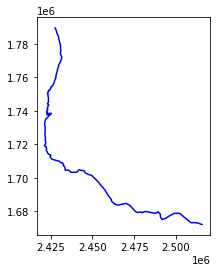

In [6]:
print(road_17.geometry)

# print(road_17)
print(type(road_17))
print(road_17.geometry.crs)
print(road_17.geometry.crs)
print(road_17.crs)
base = road_17.plot(color='blue')
print(road_17)
# road_17.plot()

epsg:2240
epsg:2240
                     timestamp_utc_gps  local_timestamp_utc  latitude_dd  \
local_timestamp_utc                                                        
2021-03-11 12:36:25       1.615466e+12         1.615466e+12    34.667701   
2021-03-11 12:36:26       1.615466e+12         1.615466e+12    34.667701   
2021-03-11 12:36:27       1.615466e+12         1.615466e+12    34.667702   
2021-03-11 12:36:28       1.615466e+12         1.615466e+12    34.667710   
2021-03-11 12:36:29       1.615466e+12         1.615466e+12    34.667729   
...                                ...                  ...          ...   
2021-03-11 13:28:27       1.615469e+12         1.615469e+12    34.986131   
2021-03-11 13:28:28       1.615469e+12         1.615469e+12    34.986301   
2021-03-11 13:28:29       1.615469e+12         1.615469e+12    34.986484   
2021-03-11 13:28:30       1.615469e+12         1.615469e+12    34.986645   
2021-03-11 13:28:31       1.615469e+12         1.615469e+12    34.98

<AxesSubplot:>

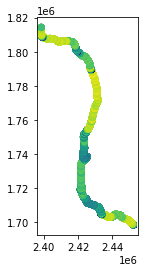

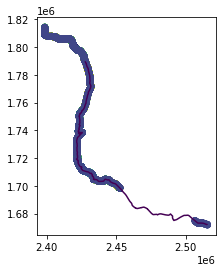

In [11]:
smartphone = gpd.GeoDataFrame(
    loc, geometry=gpd.points_from_xy(x=loc.longitude_dd, y=loc.latitude_dd)
)
road_17['speed'] = [0]
smartphone['speed'] = loc[' speed_ms']

smartphone = gpd.GeoDataFrame(smartphone, geometry=smartphone['geometry'])
smartphone = smartphone.set_crs('epsg:4326')
#smartphone = smartphone.to_crs({'init' :'epsg:4326'}) 


print(road_17.crs)
smartphone = smartphone.to_crs(road_17.crs)
road_17 = road_17.to_crs(smartphone.crs)
print(smartphone.crs)
smartphone.plot(column='speed');

combined = smartphone.append(road_17)
from shapely.geometry import Point
#print(road_17.geometry.project(Point(1,2)))
#print(road_17.geometry.interpolate(114994.071224))
#print(type(road_17.geometry))
sections = gpd.GeoSeries()
for x in np.arange(0, 10000, 50):
    point = road_17.geometry.interpolate(x)
    sections = sections.append(point)

crash_points = gpd.GeoDataFrame(
    crash, geometry=gpd.points_from_xy(x=crash.Longitude, y=crash.Latitude)
)
crash_points = crash_points.set_crs('epsg:4326')
crash_points = crash_points.to_crs(road_17.crs)
crash_points['speed'] = 5
num_sections = road_17.geometry.length/20 + 1

for index, row in all_csv_data.iterrows():
    to_interpolate = road_17.geometry.project(Point(row['longitude_dd'], row['latitude_dd']))
    
#     print(to_interpolate)
    point = road_17.geometry.interpolate(to_interpolate)
#     print(point)
    sections = sections.append(point)
sections = gpd.GeoDataFrame(geometry=sections)
sections['speed'] = 5
combined = combined.append(sections)
# combined = combined.append(crash_points)
SR_obj.gdf['speed'] = 5
combined = combined.append(SR_obj.gdf)
combined.plot(column='speed')
# smartphone.plot()

In [27]:
# Aggregates sensor data into uniform sections of the road 
# (i.e. take the mean of all rows where the points are in the interval 0-20 ft)
def standardize_sensors_to_road(sensor_data, road_linestring, interval=20, type='mean'):
    standardized = sensor_data.copy()
    standardized['section'] = standardized.apply(lambda row: round(road_linestring.project(row.geometry)/interval),axis=1)
#     for row in standardized['section']:
#         print(row)
    standardized = standardized.groupby('section').mean()
    return standardized
print(standardize_sensors_to_road(all_csv_data, road_17.geometry, interval=100))

         timestamp_utc_gps  local_timestamp_utc  latitude_dd  longitude_dd  \
section                                                                      
795.0         1.615466e+12         1.615466e+12    34.667701    -83.648070   
796.0         1.615466e+12         1.615466e+12    34.667770    -83.648156   
797.0         1.615466e+12         1.615466e+12    34.667976    -83.648404   
798.0         1.615466e+12         1.615466e+12    34.668165    -83.648638   
799.0         1.615466e+12         1.615466e+12    34.668340    -83.648849   
...                    ...                  ...          ...           ...   
2061.0        1.615469e+12         1.615468e+12    34.918089    -83.729262   
2062.0        1.615469e+12         1.615468e+12    34.918323    -83.729275   
2063.0        1.615469e+12         1.615468e+12    34.918570    -83.729270   
2064.0        1.615469e+12         1.615468e+12    34.918892    -83.729251   
2065.0        1.615469e+12         1.615469e+12    34.954485    

In [ ]:
import cv2
import numpy as np

# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name
cap = cv2.VideoCapture('camera/2021_06_03_14_57_18_660_cam_2021_06_03_14_57_18_660.mp4')

# Check if camera opened successfully
if (cap.isOpened()== False): 
    print("Error opening video stream or file")

# Read until video is completed
while(cap.isOpened()):
  # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
        # Display the resulting frame
        cv2.imshow('Frame',frame)

        # Press Q on keyboard to  exit
        key = cv2.waitKey(25)
        if key == 32:
            cv2.waitKey()
        elif key & 0xFF == ord('q'):
            break
        
  # Break the loop
    else: 
        break

# When everything done, release the video capture object
cap.release()

# Closes all the frames
cv2.destroyAllWindows()


In [ ]:
from IPython.display import Video

Video("camera/2021_06_03_14_57_18_660_cam_2021_06_03_14_57_18_660.mp4")